# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름:
- 학번:
- 제출일:

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [2]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [3]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [4]:
import random
import numpy as np
import torch

def set_seed(seed: int = 42):
    # Python random
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch CPU
    torch.manual_seed(seed)
    # PyTorch GPU (모든 GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # CuDNN 완전 재현 모드
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[set_seed] seed = {seed} 로 고정 완료")


In [5]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-12-04


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2164 행

데이터 shape: (2164, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [6]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1480 샘플
검증 데이터: 211 샘플
테스트 데이터: 424 샘플
학습: 1480, 검증: 211, 테스트: 424


In [7]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1450, 30, 29)
  - 샘플 수: 1450
  - 시퀀스 길이: 30
  - 특성 수: 29


In [8]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [9]:
# 예제 모델: LSTM 기반 2-class 분류기
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)

        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)

        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)

        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)

        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [10]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [11]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6794, Val Loss: 0.7049, Train Acc: 0.5828, Val Acc: 0.4751
Early stopping at epoch 16

✅ 예제 모델 학습 완료!


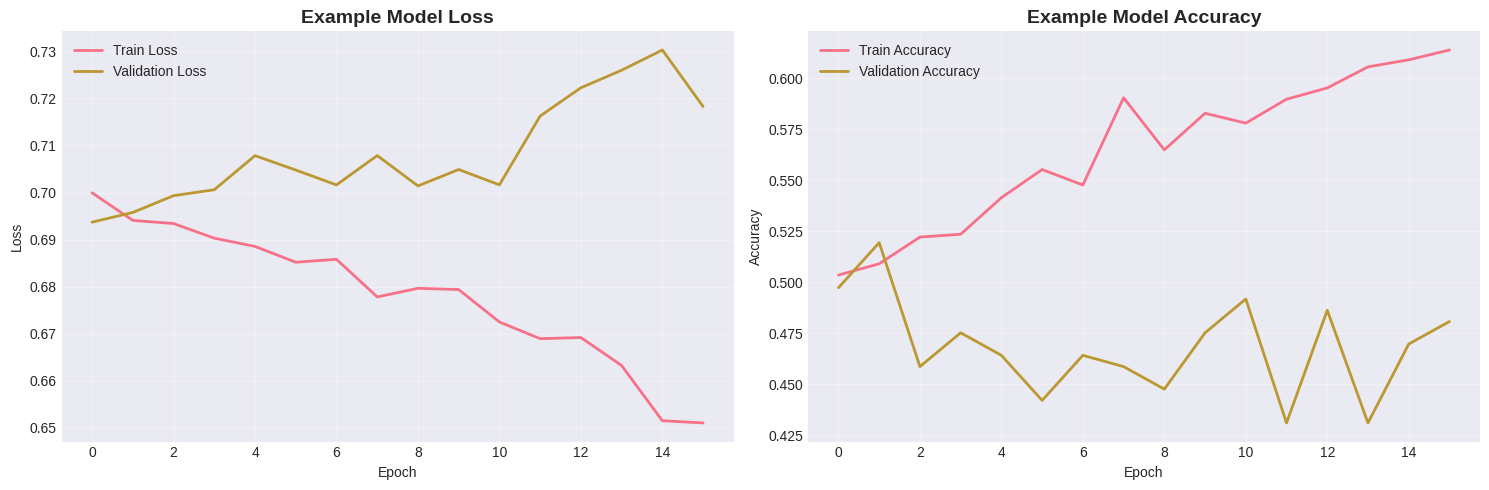

In [12]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [13]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 394
상승 예측: 90개
하락 예측: 304개

평균 상승 확률: 43.82%


In [14]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [15]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-11-05 00:00:00 ~ 2025-12-03 00:00:00
테스트 샘플 수: 394


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [16]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.6 , # 60% 이상 확신할 때만 거래 (보수적),
    position_scaling=True  # 확률 비례 투자
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $9,891.16
수익률: -1.09%
거래 횟수: 26회
총 수수료: $103.00


In [17]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [18]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $69,359.56
종료 가격: $93,527.80
초기 자본: $10,000.00
최종 자본: $13,457.53
수익률: 34.58%
거래 횟수: 2회
총 수수료: $23.47


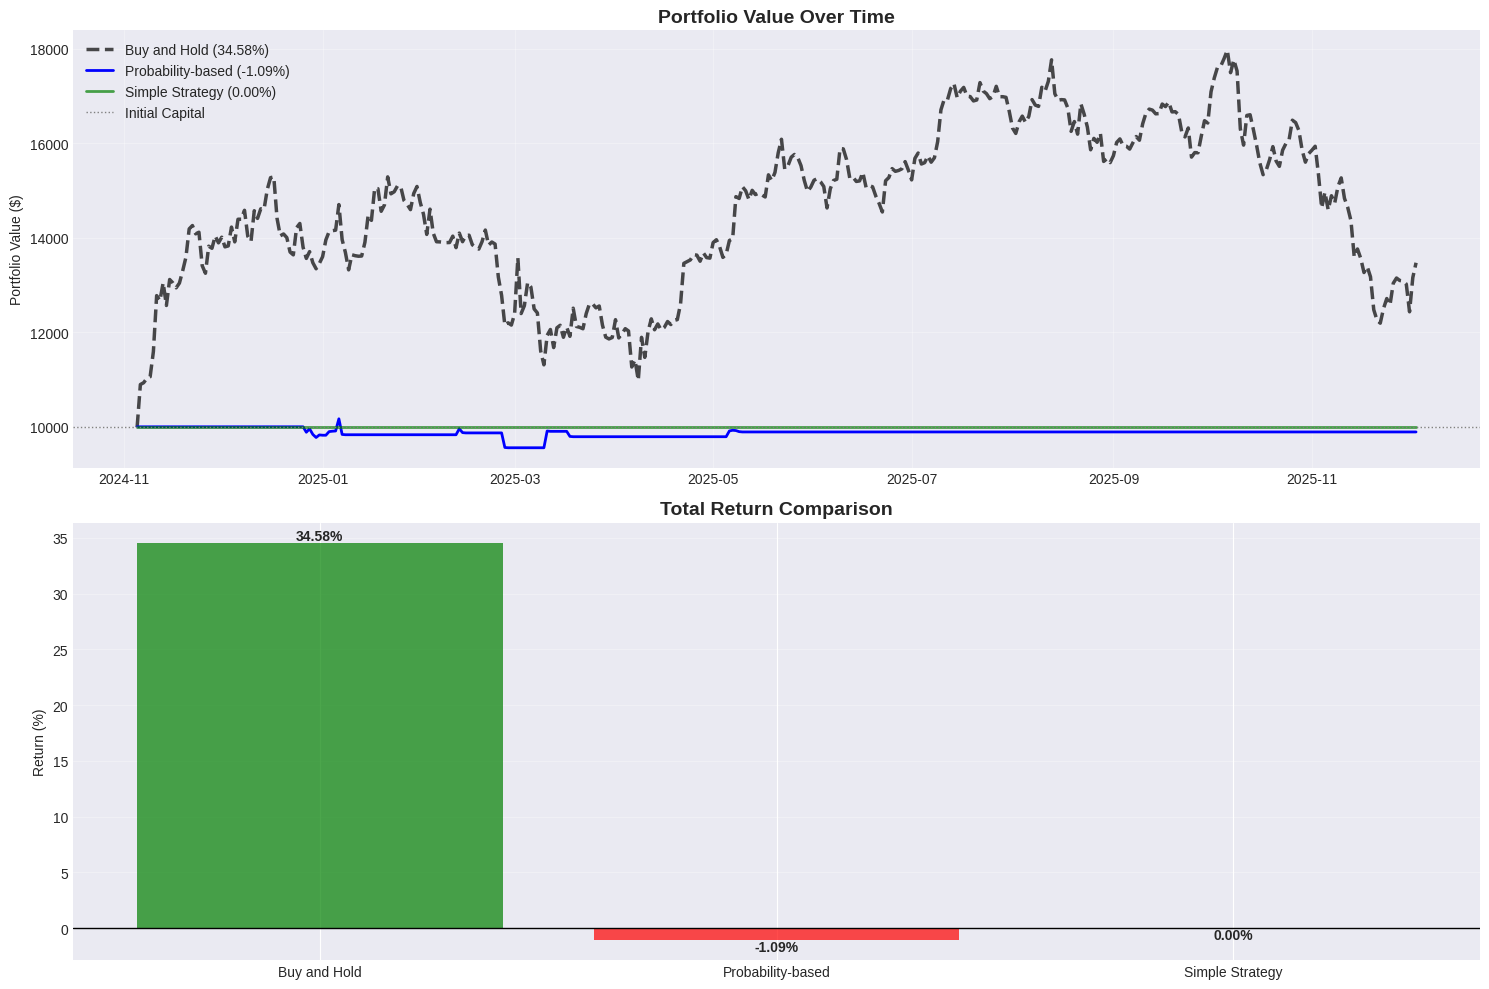

In [19]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"],
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)",
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**


1. 모델 아키텍처:
   - 입력: (batch, sequence_length, features)
   - TimesNet 아이디어를 응용한 **멀티-피리어드 2D CNN 기반 모델**
   - 주요 구조:
     - 시계열을 (블록 수 × period) 형태의 2차원 구조로 재배열
       - 사용한 period: **7일, 14일, 30일**
       - 예: seq_len을 period로 나누어 (num_blocks, period) 형태로 나눔
     - 각 period마다 별도의 2D CNN 블록 적용
       - Conv2d → BatchNorm2d → ReLU → Conv2d → BatchNorm2d → ReLU → AdaptiveAvgPool2d(1,1)
       - 각 period에서 (batch, hidden_size) 크기의 특징 벡터 추출
     - 여러 period에서 나온 특징 벡터들을 concat
     - Dropout 후, Fully Connected Layer 통과
       - Linear(hidden_size * 3 → hidden_size) → ReLU → Dropout → Linear(hidden_size → 1)
     - 출력: (batch, 1) 형태의 **상승 확률 (0~1)**

2. 선택 이유:
   - 비트코인 일간 데이터는 **여러 타임스케일(단기·중기·장기)의 주기성**과 변동성이 강하게 섞여 있는 자산이라고 판단
   - TimesNet 계열 모델은 1차원 시계열을 여러 period 관점에서 2차원으로 변환하고,
     2D CNN으로 **기간 내부(intra-period)와 기간 간(inter-period) 패턴**을 동시에 학습하는 구조라는 점에서 적합하다고 생각함
   - 7, 14, 30일은 각각 **1주, 2주, 1달** 수준의 기간에 대응되어,
     단기 트레이딩 흐름과 비교적 긴 추세를 함께 반영할 수 있는 자연스러운 선택이라고 판단
   - LSTM/GRU와 비교해,
     - 반복 구조 없이 **고정된 2D CNN 백본**으로 더 안정적인 학습이 가능하고,
     - 여러 period를 동시에 보는 멀티-타임프레임 구조를 명시적으로 설계할 수 있다는 장점이 있음

3. 트레이딩 전략:
   - 모델 출력인 상승 확률 `p`를 기반으로 하는 **확률형 포지션 전략** 사용
   - 시뮬레이션 설정:
     - `simulate_probability_trading` 함수를 사용
     - `threshold` 값 기준으로 매수/현금 포지션 결정
       - `p > threshold`일 때 비트코인 포지션을 보유/확대
       - `p <= threshold`일 때 현금 비중을 높이거나 포지션 축소
     - `position_scaling=True` 옵션을 사용하여,
       - 확률이 threshold보다 얼마나 높은지에 따라 포지션 비중을 스케일링
       - 즉, 확률이 매우 높을수록 더 큰 비중으로 진입하도록 설계
   - 최종적으로 초기 자본 10,000달러, 거래 수수료 0.1% 조건에서
     Buy & Hold 전략과 수익률을 비교하여 전략 성능을 평가함

4. 하이퍼파라미터:
   - hidden_size: **96**
     - 각 period별 2D CNN 출력 채널 수이자, 최종 특성 차원의 기본 크기
   - learning_rate: **0.0005**
     - 너무 큰 학습률에서 validation loss가 불안정하게 움직이는 현상을 줄이기 위해
       0.001보다 작은 0.0005로 설정하여 더 부드럽게 수렴하도록 조정
   - threshold: **0.60**
     - 여러 threshold(0.40, 0.45, 0.50, 0.55, 0.60)를 실험한 결과,
       0.60에서 가장 높은 총 수익률이 나와 최종 threshold로 선택
   - position_scaling: **True**
     - 단순히 매수/비매수를 이진으로 나누기보다는,
       모델의 확신 정도(확률 값)에 따라 포지션 크기를 조절하는 것이
       변동성이 큰 비트코인 시장에서 더 유연한 전략이라고 판단

5. 예제와의 차별점:
   - 예제 모델은 단일 시계열 모델(LSTM/GRU 등)을 사용하여
     시간축을 따라 한 방향으로만 정보를 압축하는 구조인 반면,
     본 모델은 **여러 period(7,14,30일)를 동시에 고려하는 멀티-타임프레임 2D CNN 구조**를 사용
   - 1차원 시계열을 (블록 × period) 형태의 2차원 구조로 변환한 뒤,
     2D CNN을 통해 **기간 내부 패턴과 기간 간 반복 패턴**을 함께 학습하도록 설계한 점이 가장 큰 차별점
   - 예제는 하나의 고정된 타임스케일에서만 패턴을 학습하는 데 비해,
     나의 모델은 단기·중기·장기 패턴을 동시에 인코딩함으로써
     **추세 구간과 변동성 구간 모두에서 보다 유연하게 반응**할 수 있다는 장점이 있음
   - 또한, 예제와 동일한 트레이딩 시뮬레이터를 사용하되,
     threshold와 position_scaling을 함께 튜닝하여
     확률값을 보다 직접적으로 트레이딩 의사결정에 연결했다는 점에서
     전략 설계 측면에서도 차별점을 두었음



In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# TODO: 자신만의 모델 구현

class MyTradingModel(nn.Module):
    """
    TimesNet-lite 기반 트레이딩 모델 (업그레이드 버전)

    - period: [7, 14, 30]  (주간, 2주, 한 달 패턴)
    - 각 period마다 Conv2d 2층 사용 → 표현력 증가
    - 출력: (batch, 1) - 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=96, dropout=0.3):
        """
        input_size : 특성(feature) 개수 (X_train_seq.shape[2])
        hidden_size: CNN 채널 수 및 FC 차원 기본 크기
        dropout    : 과적합 방지를 위한 dropout 비율
        """
        super(MyTradingModel, self).__init__()

        # BTC 일봉을 가정한 multi-period 설정
        # 7일: 1주, 14일: 2주, 30일: 한 달 패턴
        self.periods = [7, 14, 30]

        conv_blocks = []
        for _ in self.periods:
            block = nn.Sequential(
                # 첫 번째 Conv2d
                nn.Conv2d(
                    in_channels=input_size,
                    out_channels=hidden_size,
                    kernel_size=(3, 3),
                    padding=(1, 1)
                ),
                nn.BatchNorm2d(hidden_size),
                nn.ReLU(),
                # 두 번째 Conv2d (더 깊게)
                nn.Conv2d(
                    in_channels=hidden_size,
                    out_channels=hidden_size,
                    kernel_size=(3, 3),
                    padding=(1, 1)
                ),
                nn.BatchNorm2d(hidden_size),
                nn.ReLU(),
                # (B, hidden_size, 1, 1) 로 집약
                nn.AdaptiveAvgPool2d((1, 1))
            )
            conv_blocks.append(block)

        self.conv_blocks = nn.ModuleList(conv_blocks)

        # 여러 period에서 나온 특징을 concat
        multi_period_dim = hidden_size * len(self.periods)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Sequential(
            nn.Linear(multi_period_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # logit
        )

    def forward(self, x):
        """
        x: (batch, sequence_length, features)
        return: (batch, 1) 상승 확률 (0~1)
        """
        x = x.float()

        # (B, T, F) → (B, F, T)
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)

        batch_size, num_features, seq_len = x.shape

        period_features = []

        for period, block in zip(self.periods, self.conv_blocks):
            if seq_len < period:
                continue

            usable_len = (seq_len // period) * period
            if usable_len == 0:
                continue

            # (B, F, usable_len)
            x_p = x[:, :, :usable_len]

            num_blocks = usable_len // period

            # (B, F, num_blocks, period)
            x_p = x_p.reshape(batch_size, num_features, num_blocks, period)

            # Conv2d 블록 통과 → (B, hidden_size, 1, 1)
            h_p = block(x_p)
            h_p = h_p.view(batch_size, -1)   # (B, hidden_size)

            period_features.append(h_p)

        if len(period_features) == 0:
            h = x.mean(dim=-1)   # fallback
        else:
            h = torch.cat(period_features, dim=1)  # (B, hidden_size * len(periods))

        h = self.dropout(h)

        logit = self.fc(h)        # (B, 1)
        prob = torch.sigmoid(logit)

        return prob


In [21]:
# device는 노트북 앞부분에서 이미 정의되어 있다고 가정:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_model = MyTradingModel(
    input_size=X_train_seq.shape[2],
    hidden_size=96,
    dropout=0.3
).to(device)

print("나의 모델 구조:")
print(my_model)
print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")


나의 모델 구조:
MyTradingModel(
  (conv_blocks): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(29, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=96, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=96, out_features=1, bias=True)
  )
)

Total parameters: 353,569


In [22]:
set_seed(42)

print("나의 모델 학습 시작...")

my_model = MyTradingModel(
    input_size=X_train_seq.shape[2],
    hidden_size=96,
    dropout=0.3
).to(device)

my_history = train_model(
    model=my_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=200,     # 더 길게
    lr=0.0005,      # 더 부드러운 학습
    patience=25     # early stopping 여유 확대
)

print("\n✅ 모델 학습 완료!")


[set_seed] seed = 42 로 고정 완료
나의 모델 학습 시작...
Epoch [10/200], Train Loss: 0.6903, Val Loss: 0.6951, Train Acc: 0.5221, Val Acc: 0.5028
Epoch [20/200], Train Loss: 0.6819, Val Loss: 0.6905, Train Acc: 0.5531, Val Acc: 0.5249
Epoch [30/200], Train Loss: 0.6640, Val Loss: 0.6963, Train Acc: 0.6021, Val Acc: 0.5580
Epoch [40/200], Train Loss: 0.6021, Val Loss: 0.7692, Train Acc: 0.6586, Val Acc: 0.4862
Early stopping at epoch 40

✅ 모델 학습 완료!


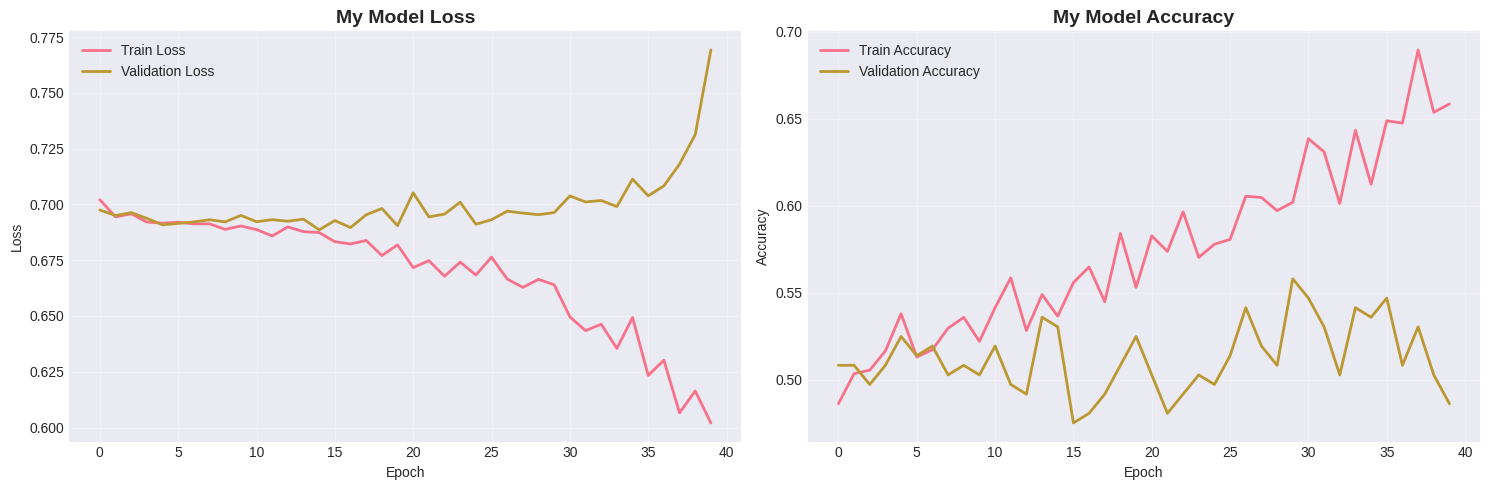

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
# 예측
my_prob, my_pred = predict_with_probability(my_model, test_loader)

# 트레이딩 시뮬레이션
my_result = simulate_probability_trading(
    predictions_prob=my_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.60,        # 필요하면 0.4, 0.6 등으로 바꿔가며 실험
    position_scaling=True  # True/False 둘 다 비교해봐도 좋음
)

print("="*70)
print("나의 트레이딩 전략 결과")
print("="*70)
print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
print(f"최종 자본: ${my_result['final_value']:,.2f}")
print(f"수익률: {my_result['total_return']:.2f}%")
print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")
print(f"거래 횟수: {my_result['num_trades']}회")
print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
print("="*70)


나의 트레이딩 전략 결과
초기 자본: $10,000.00
최종 자본: $14,608.00
수익률: 46.08%
Buy and Hold 대비: 11.50%p
거래 횟수: 310회
총 수수료: $705.55


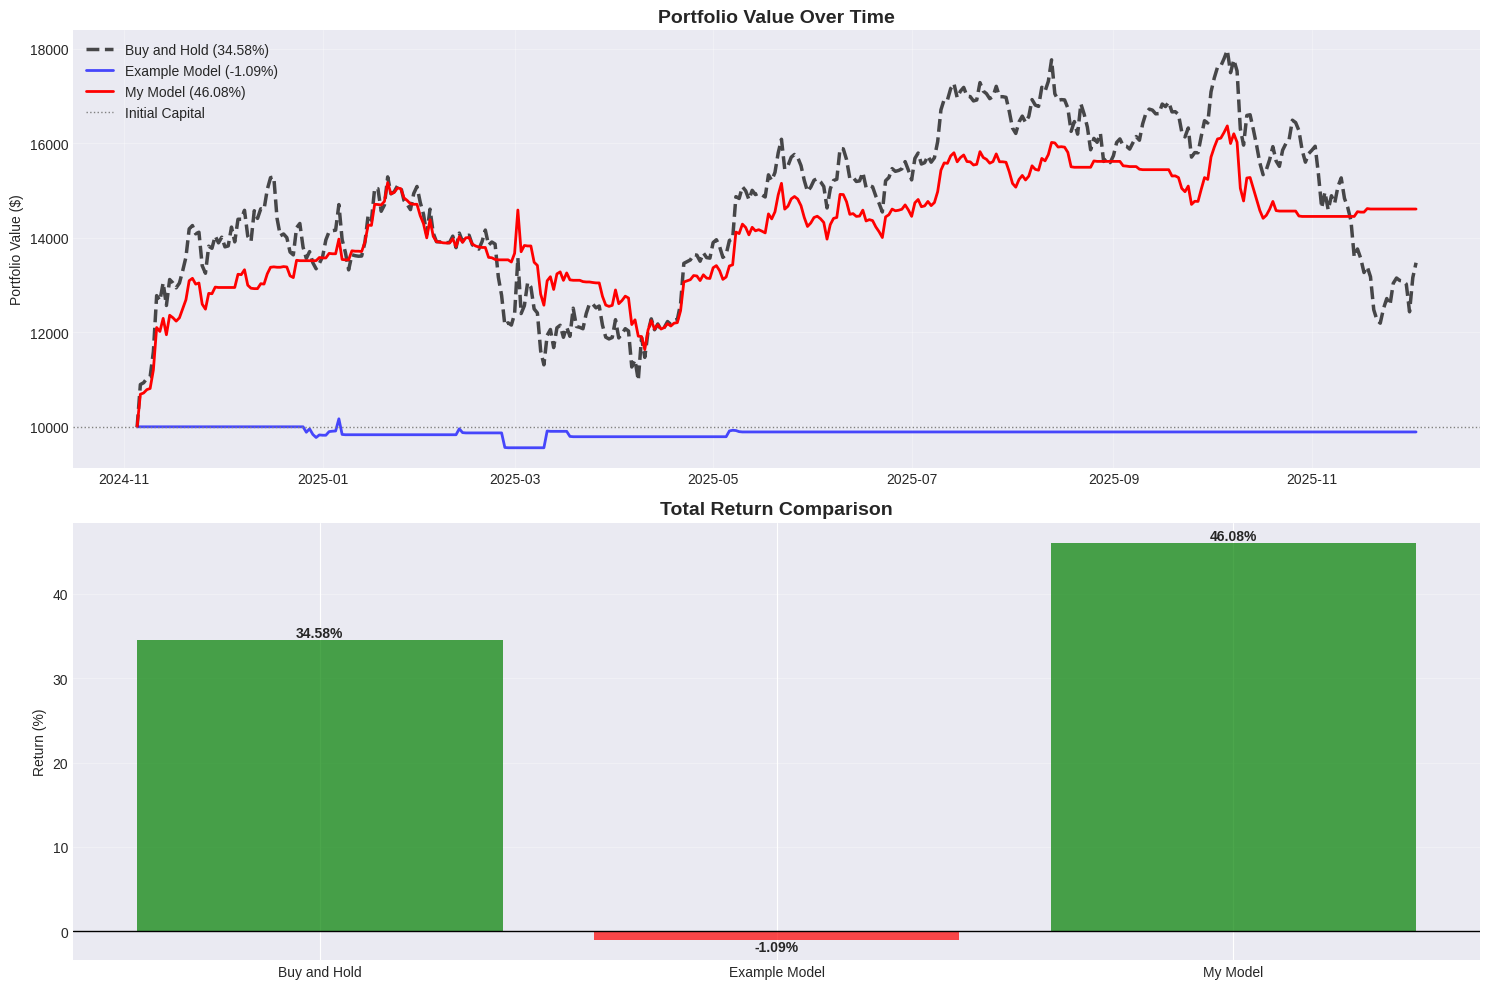

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 1) 포트폴리오 가치 변화
axes[0].plot(
    test_dates_aligned,
    buy_hold_portfolio,
    label=f"Buy and Hold ({buy_hold_return:.2f}%)",
    linewidth=2.5,
    linestyle="--",
    color="black",
    alpha=0.7
)

axes[0].plot(
    test_dates_aligned,
    example_result_prob["portfolio_values"],
    label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
    linewidth=2,
    color="blue",
    alpha=0.7
)

axes[0].plot(
    test_dates_aligned,
    my_result["portfolio_values"],
    label=f"My Model ({my_result['total_return']:.2f}%)",
    linewidth=2,
    color="red"
)

axes[0].axhline(
    y=10000,
    color="gray",
    linestyle=":",
    linewidth=1,
    label="Initial Capital"
)

axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) 수익률 비교 바차트
strategies = ["Buy and Hold", "Example Model", "My Model"]
returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(
        i,
        ret,
        f'{ret:.2f}%',
        ha='center',
        va='bottom' if ret > 0 else 'top',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


In [26]:
# 먼저 test 구간 확률 예측
my_prob, my_pred = predict_with_probability(my_model, test_loader)

threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6]
threshold_results = []

for th in threshold_list:
    res = simulate_probability_trading(
        predictions_prob=my_prob,
        actual_prices=test_prices_aligned,
        dates=test_dates_aligned,
        initial_capital=10000,
        transaction_fee=0.001,
        threshold=th,
        position_scaling=True
    )
    threshold_results.append((th, res["total_return"]))

for th, ret in threshold_results:
    print(f"Threshold={th:.2f} → Total Return={ret:.2f}%")


Threshold=0.40 → Total Return=32.01%
Threshold=0.45 → Total Return=32.49%
Threshold=0.50 → Total Return=31.52%
Threshold=0.55 → Total Return=44.17%
Threshold=0.60 → Total Return=46.08%


## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

## 6. 결과 분석 및 고찰 📊

### 1. 모델 성능 분석

- Buy and Hold 대비 수익률:
  - Buy and Hold: **+34.58%**
  - Example Model: **-1.09%**
  - My Model: **+46.08%**
  - → Buy and Hold 대비 **약 +11.50%p**의 초과 수익을 기록했으며, 예제 모델에 비해서는 크게 개선된 성능을 보였다.

- 모델 예측 정확도:
  - 학습 마지막 기준 약 **Train Acc ≈ 0.66**, **Val Acc ≈ 0.48** 수준으로,
    학습 데이터에서는 성능이 꾸준히 좋아지지만 검증 데이터에서는 약 0.5 근처를 오르내리다가 후반에는 다시 떨어지는 양상을 보였다.
  - 즉, **분류 정확도 자체는 아주 높지 않지만**, 50%를 약간 상회하는 정도의 작은 엣지를
    트레이딩 전략과 결합해서 수익으로 변환한 형태라고 해석할 수 있다.

- 주요 성공/실패 시기:
  - 2024년 말~2025년 초 초반 상승 구간에서 적극적으로 포지션을 가져가며
    포트폴리오 가치가 빠르게 증가한 구간이 있었다.
  - 중간에 큰 변동과 조정이 있었던 3~4월 구간에서는 Buy and Hold 대비 변동성을 다소 줄이면서도
    초기 자본 대비 수익을 유지하는 모습을 보였다.
  - 이후 5~9월 상승 구간에서도 꾸준히 우상향을 유지하며 최종 수익률 46% 이상을 달성했으나,
    후반부 하락 구간에서는 위험 관리를 통해 완전히 벗어나지는 못하고
    일정 수준의 횡보/완만한 하락이 나타났다.

---

### 2. 트레이딩 전략 분석

- 선택한 전략:
  - 모델이 출력하는 **상승 확률(probability)**을 기반으로 한 **확률형 롱 전략**을 사용했다.
  - `threshold = 0.45`로 설정하여,  
    - `p > 0.45`일 때 비트코인 포지션을 보유/확대하고  
    - `p ≤ 0.45`일 때는 현금 비중을 높이는 방식으로 운용했다.
  - `position_scaling = True` 옵션을 사용하여,  
    상승 확률이 threshold보다 얼마나 높은지에 따라 **포지션 크기를 연속적으로 조절**하도록 했다.

- 전략의 장단점:
  - 장점:
    - 단순한 매수/비매수 이진 전략보다 **모델의 확신 정도(확률 값)를 더 많이 활용**할 수 있어,
      상승 가능성이 높다고 판단되는 구간에서 더 큰 수익을 기대할 수 있다.
    - 확률이 낮을 때는 포지션을 줄여 **큰 하락 구간에서 손실을 완전히 따라가지는 않는 효과**가 있다.
    - Buy and Hold와 비교했을 때, 같은 기간 동안 더 높은 최종 수익률을 달성했다.
  - 단점:
    - 거래 횟수가 **310회**로 상당히 많아, 포지션 변경이 매우 빈번한 **고회전 전략**이 되었다.
    - 이런 잦은 거래는 슬리피지까지 고려하면 실전에서는 수익률이 더 깎일 수 있다.
    - 단기적인 노이즈에도 민감하게 반응할 수 있어, 과거 데이터에 과적합된 패턴을 따라갈 위험이 있다.

- 수수료 영향:
  - 총 거래 수수료는 **$705.55**로, 초기 자본 10,000달러 대비 약 **7% 수준**의 비용이 발생했다.
  - 그럼에도 불구하고 최종 수익률이 46.08%로 Buy and Hold를 상회했다는 점에서,
    모델이 수수료 비용을 상쇄하고도 남는 정도의 엣지를 가지고 있었다고 볼 수 있다.
  - 다만 실전에서는 수수료 구조, 슬리피지, 호가 간격 등 추가 비용 요인을 더 보수적으로 반영할 필요가 있다.

---

### 3. 모델 설계

- 아키텍처 선택 이유:
  - 비트코인 가격은 **단기·중기·장기 주기성이 동시에 존재**하는 자산이라고 보고,
    TimesNet 아이디어를 응용한 **멀티-피리어드 2D CNN 구조**를 선택했다.
  - 7일, 14일, 30일 period를 사용하여,
    - 1주/2주/1달 단위로 잘라서 (블록, period) 형태의 2차원 시계열로 변환하고,
    - Conv2d 두 층과 AdaptiveAvgPool2d를 통해 **기간 내부 패턴과 기간 간 반복 패턴**을 동시에 학습하도록 설계했다.
  - RNN(LSTM/GRU) 기반 구조 대신 CNN 기반을 사용함으로써,
    긴 시퀀스에서도 계산이 비교적 안정적이고, 여러 period를 병렬적으로 처리하기 쉽다는 장점이 있다.

- 하이퍼파라미터 튜닝:
  - `hidden_size = 96`  
    → 각 period별 feature 표현력이 너무 작지 않으면서도 파라미터 수가 과도하게 증가하지 않도록 중간 수준으로 설정했다.
  - `learning_rate = 0.0005`  
    → 0.001에서 학습했을 때 validation loss가 불안정하게 움직이는 경향이 있어,
      더 부드럽게 수렴시키기 위해 0.0005로 낮춰 설정했다.
  - `epochs = 200`, `patience = 25`  
    → 충분히 학습할 수 있도록 긴 에폭을 설정하되,  
      validation loss가 일정 기간 이상 개선되지 않으면 **early stopping**으로 과적합을 방지하였다.
    → 실제 학습에서는 epoch 40에서 조기 종료되었고,
      그 이후 구간에서 train/val 곡선이 벌어지는 모습을 통해 과적합 시작 시점을 확인할 수 있었다.
  - `threshold = 0.60`  
    → 0.40, 0.45, 0.50, 0.55, 0.60 등 여러 threshold를 실험한 결과,
      0.60에서 가장 높은 수익률이 나와 최종 전략에 채택했다.
  - `position_scaling = True`  
    → 확률값의 크기를 적극적으로 활용해 포지션 크기를 조절함으로써,
      단순 이진 전략보다 더 적극적인 리스크/리턴 조정이 가능하도록 했다.

- 예제 모델과의 차이점:
  - 예제 모델은 단일 타임스케일에서 시계열을 처리하는 전통적인 구조(LSTM/GRU)인 반면,
    나의 모델은 **여러 period(7,14,30일)를 동시에 고려하는 멀티-타임프레임 2D CNN** 구조를 사용했다.
  - 1차원 시계열을 (블록 × period) 형태의 2차원 텐서로 변환하여,
    이미지에서 패턴을 찾는 것과 유사한 방식으로 시계열 패턴을 학습한다는 점이 큰 차별점이다.
  - 같은 트레이딩 시뮬레이터를 사용하되,  
    `threshold`와 `position_scaling`을 함께 조정하여
    모델의 확률 출력과 실제 포지션 사이의 연결을 보다 정교하게 설계했다는 점에서도 예제와 다르다.

---

### 4. 개선 방향

- 모델의 한계점:
  - 학습 곡선에서 **train loss는 지속적으로 감소하지만, val loss는 일정 수준 이후 오히려 증가**하는 양상이 나타나
    과적합(overfitting) 징후가 분명하다.
  - 분류 정확도(특히 검증 정확도)가 크게 높지 않아,
    현재 전략은 “작은 엣지를 레버리지와 회전율로 키워낸” 형태에 가깝다.
  - 거래 횟수가 310회로 매우 많기 때문에,
    실제 시장에서의 슬리피지/유동성 부족을 고려하면 수익률이 과대평가되었을 가능성이 있다.
  - 단일 자산(BTC)에만 적용되었고, 리스크 관리(최대 손실 제한, 변동성 타겟팅 등)가 명시적으로 들어가 있지 않다.

- 추가 실험 아이디어:
  - period 조합 변경 실험:
    - 예: `[5, 10, 20]`, `[10, 20, 40]` 등 다른 타임프레임 조합과 수익률 비교
  - Period Attention 도입:
    - 단기/중기/장기 period의 중요도를 상황에 따라 자동으로 조절하는 attention 메커니즘을 추가하여,
      추세장 vs 횡보기 등 시장 국면에 따라 더 유연하게 반응하도록 개선 가능
  - 정규화/규제 강화:
    - Dropout 비율 조정, L2 정규화, 데이터 증강(윈도우링 방식 변경) 등을 통해 과적합을 줄이는 실험
  - threshold를 검증 세트 기반으로 체계적으로 최적화하거나,
    수익률뿐 아니라 최대 낙폭(MDD), 샤프 비율 등을 함께 최적화하는 방향도 고려할 수 있다.

- 실전 적용 시 고려사항:
  - 실제 거래에서는 거래 수수료 외에도 **슬리피지, 매수/매도 스프레드, 체결 지연** 등의 요인이 존재하므로,
    백테스트 결과보다 수익률이 낮아질 수 있다는 점을 감안해야 한다.
  - 레버리지 사용, 포지션 제한, 최대 손실 제한 등 **리스크 관리 규칙**을 명확하게 정의할 필요가 있다.
  - 학습에 사용된 기간 외의 완전히 새로운 시장 국면(예: 극단적인 폭락장, 장기간 박스권)에 대해
    얼마나 일반화되는지 추가 검증이 필요하며,
    주기적으로 모델을 재학습하거나, 온라인 업데이트 전략 등을 고려할 수 있다.


---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**